# Feature Engineering
## Goal
- Investigate relationship between features and target
- Look for trends in data
- Develop features to provide better information to classification models
 
## Metrics Used for Analysis
- Client is interested in reducing costs on customers who will stop doing business with it
 - Goal is to reduce the spend on the customers who will ultimately cancel their subscriptions
 - Will need to reduce the number of customers who we think are not leaving, but do (i.e., reduce the number of false positives)
- However, it is also important not to alienate those customers who would not cancel their subscription (i.e., to not increase the number of false negatives)
- Because we would like to minimize both false positives and false negatives, F1-score is appropriate measure to consider in this analysis

##  Conclusion
- Adding the following two features improved F1 Scores in Logistic Regression Model:
    - Bin service calls > 3
    - Bin day_mins > 225
- Baseline F1 Training Score = 0.61
- Baseline F1 Test Score = 0.59

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LogisticRegression

# Transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.over_sampling import SMOTE

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score

# Pipelines
from imblearn.pipeline import make_pipeline

import sys
sys.path.append('../../')
import src.classes as cl

### Import and Clean Data

In [2]:
df = pd.read_csv('../../data/raw/churn_dataset.csv')
# Drop phone numbers because all are unique
df.drop(columns = 'phone number', inplace = True)

# Remove spaces from column names
df.rename({'account length':'acct_length', 'area code':'area_code', 
           'international plan':'intl_plan', 
           'voice mail plan':'vm_plan', 'number vmail messages':'no_vm_msg', 
           'total day minutes':'day_mins', 'total day calls':'day_calls', 
           'total day charge':'day_chrg', 'total eve minutes':'eve_mins', 
           'total eve calls':'eve_calls', 'total eve charge':'eve_chrg', 
           'total night minutes':'night_mins', 
           'total night calls':'night_calls', 
           'total night charge':'night_chrg', 
           'total intl minutes':'intl_mins', 'total intl calls':'intl_calls', 
           'total intl charge':'intl_chrg', 
           'customer service calls':'service_calls'}, axis=1, inplace=True)

# Replace area codes with city names for easier identification
df['city'] = df.area_code.replace({415:'San_Francisco', 408:'San_Jose', 510:'Oakland'})
df.drop(columns = 'area_code', inplace = True)

# Convert boolean to binary
df.churn = df.churn.astype(int)

# Set values for consistency throughtout
random_state = 45
cv = 5

### Investigate data

In [3]:
df.head()

state  acct_length intl_plan vm_plan  no_vm_msg  day_mins  day_calls  \
0    KS          128        no     yes         25     265.1        110   
1    OH          107        no     yes         26     161.6        123   
2    NJ          137        no      no          0     243.4        114   
3    OH           84       yes      no          0     299.4         71   
4    OK           75       yes      no          0     166.7        113   

   day_chrg  eve_mins  eve_calls  eve_chrg  night_mins  night_calls  \
0     45.07     197.4         99     16.78       244.7           91   
1     27.47     195.5        103     16.62       254.4          103   
2     41.38     121.2        110     10.30       162.6          104   
3     50.90      61.9         88      5.26       196.9           89   
4     28.34     148.3        122     12.61       186.9          121   

   night_chrg  intl_mins  intl_calls  intl_chrg  service_calls  churn  \
0       11.01       10.0           3       2.70              1      0   
1       11.45       13.7           3       3.70              1      0   
2        7.32       12.2           5       3.29              0      0   
3        8.86        6.6           7       1.78              2      0   
4        8.41       10.1           3       2.73              3      0   

            city  
0  San_Francisco  
1  San_Francisco  
2  San_Francisco  
3       San_Jose  
4  San_Francisco

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   state          3333 non-null   object 
 1   acct_length    3333 non-null   int64  
 2   intl_plan      3333 non-null   object 
 3   vm_plan        3333 non-null   object 
 4   no_vm_msg      3333 non-null   int64  
 5   day_mins       3333 non-null   float64
 6   day_calls      3333 non-null   int64  
 7   day_chrg       3333 non-null   float64
 8   eve_mins       3333 non-null   float64
 9   eve_calls      3333 non-null   int64  
 10  eve_chrg       3333 non-null   float64
 11  night_mins     3333 non-null   float64
 12  night_calls    3333 non-null   int64  
 13  night_chrg     3333 non-null   float64
 14  intl_mins      3333 non-null   float64
 15  intl_calls     3333 non-null   int64  
 16  intl_chrg      3333 non-null   float64
 17  service_calls  3333 non-null   int64  
 18  churn   

***Data types are appropriate and do not need to be converted***

In [5]:
df.describe()

acct_length    no_vm_msg     day_mins    day_calls     day_chrg  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean    101.064806     8.099010   179.775098   100.435644    30.562307   
std      39.822106    13.688365    54.467389    20.069084     9.259435   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%      74.000000     0.000000   143.700000    87.000000    24.430000   
50%     101.000000     0.000000   179.400000   101.000000    30.500000   
75%     127.000000    20.000000   216.400000   114.000000    36.790000   
max     243.000000    51.000000   350.800000   165.000000    59.640000   

          eve_mins    eve_calls     eve_chrg   night_mins  night_calls  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean    200.980348   100.114311    17.083540   200.872037   100.107711   
std      50.713844    19.922625     4.310668    50.573847    19.568609   
min       0.000000     0.000000     0.000000    23.200000    33.000000   
25%     166.600000    87.000000    14.160000   167.000000    87.000000   
50%     201.400000   100.000000    17.120000   201.200000   100.000000   
75%     235.300000   114.000000    20.000000   235.300000   113.000000   
max     363.700000   170.000000    30.910000   395.000000   175.000000   

        night_chrg    intl_mins   intl_calls    intl_chrg  service_calls  \
count  3333.000000  3333.000000  3333.000000  3333.000000    3333.000000   
mean      9.039325    10.237294     4.479448     2.764581       1.562856   
std       2.275873     2.791840     2.461214     0.753773       1.315491   
min       1.040000     0.000000     0.000000     0.000000       0.000000   
25%       7.520000     8.500000     3.000000     2.300000       1.000000   
50%       9.050000    10.300000     4.000000     2.780000       1.000000   
75%      10.590000    12.100000     6.000000     3.270000       2.000000   
max      17.770000    20.000000    20.000000     5.400000       9.000000   

             churn  
count  3333.000000  
mean      0.144914  
std       0.352067  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [6]:
df.isna().any()

state            False
acct_length      False
intl_plan        False
vm_plan          False
no_vm_msg        False
day_mins         False
day_calls        False
day_chrg         False
eve_mins         False
eve_calls        False
eve_chrg         False
night_mins       False
night_calls      False
night_chrg       False
intl_mins        False
intl_calls       False
intl_chrg        False
service_calls    False
churn            False
city             False
dtype: bool

***No data is missing***

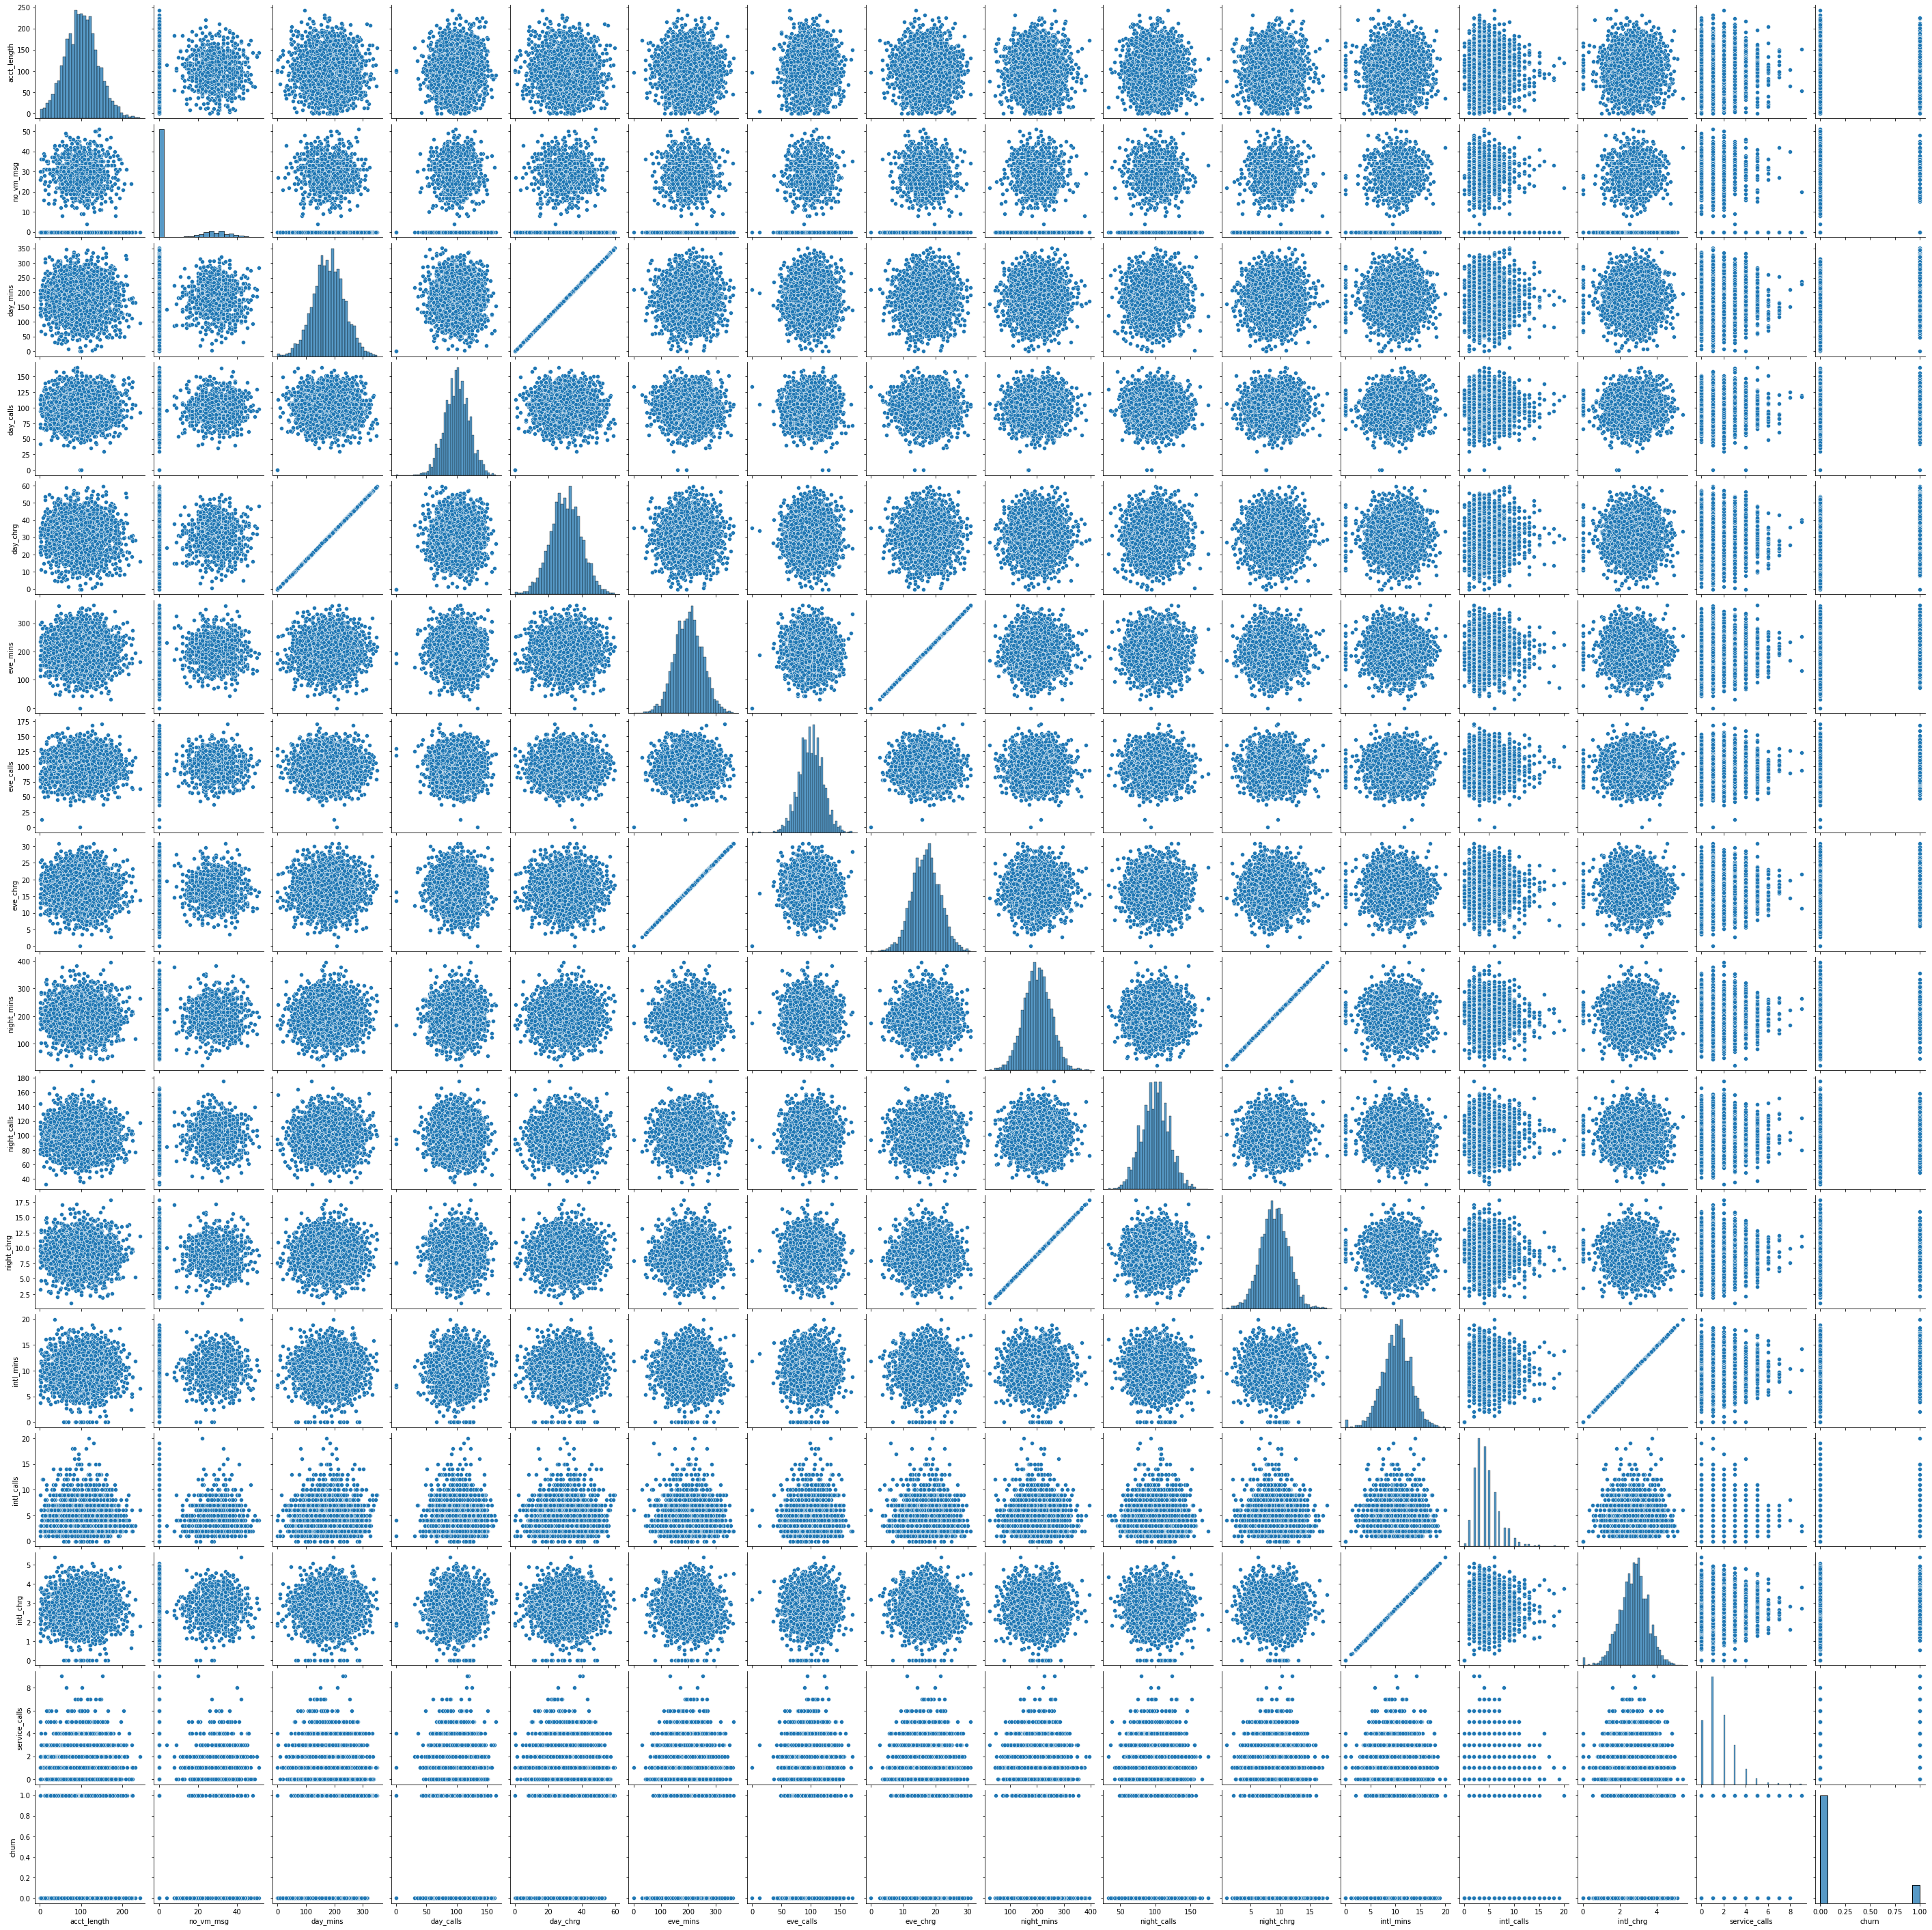

In [7]:
sns.pairplot(df)

***Because there is a linear relationship between minutes and charge, I will drop day_chrg, eve_chrg, night_chrg and intl_chrg (redundant features)***

In [8]:
df.drop(columns = ['day_chrg', 'eve_chrg', 'night_chrg', 'intl_chrg'], inplace = True)
X = df.drop(columns = 'churn')
y = df.churn

### Compare difference between churned and unchurned categorical features

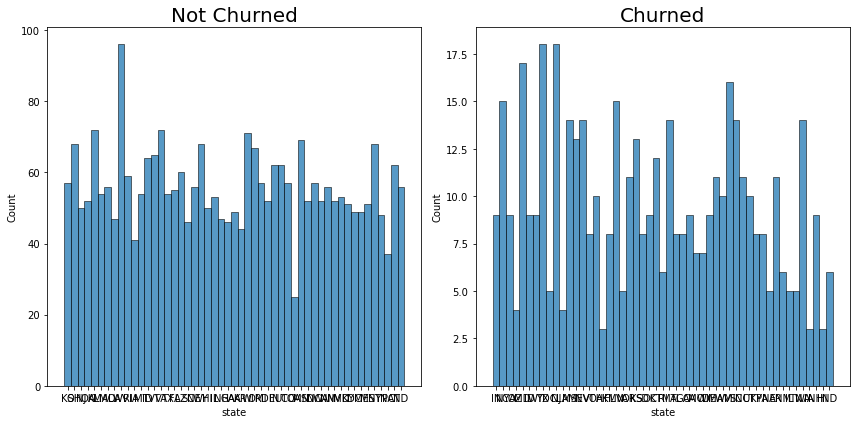

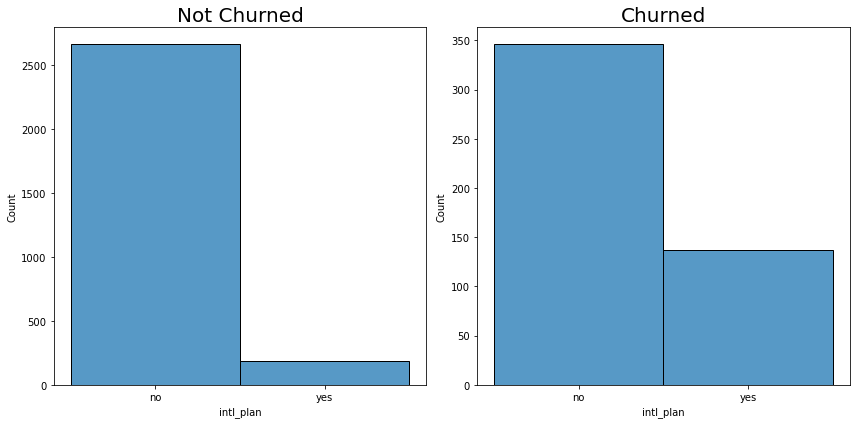

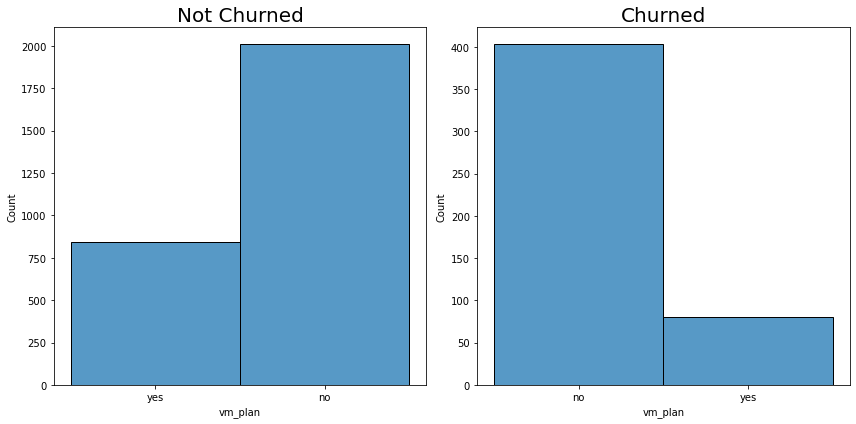

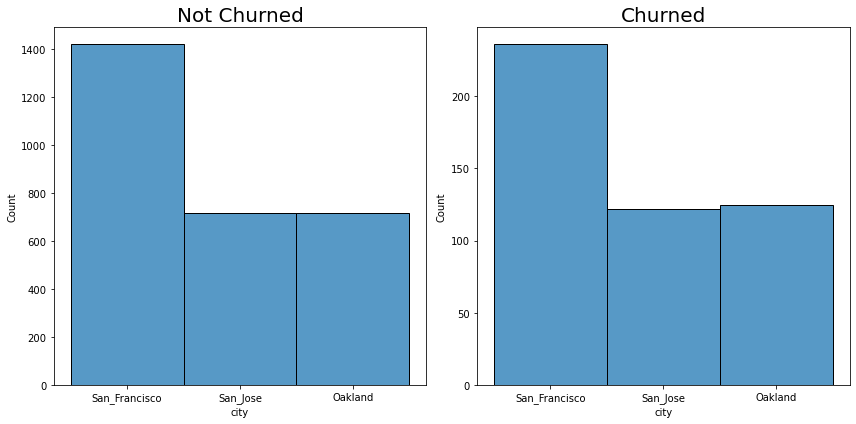

In [9]:
cat_features = [col for col in X.columns if X[col].dtype in [np.object]]
for i in cat_features:
    fig, [ax1, ax2] = plt.subplots(ncols = 2, nrows = 1, figsize=(12, 6))
    g1 = sns.histplot(data = df[df.churn == False], x = i, ax=ax1)
    g2 = sns.histplot(data = df[df.churn == True], x = i, ax=ax2)
    g1.set_title('Not Churned', fontsize=20)
    g2.set_title('Churned', fontsize=20)
    plt.tight_layout()
    plt.show();

***There does not appear to be a significant difference between churned and unchurned categorical data (note, 'yes' and 'no' are reversed for vm_plan)***

In [10]:
# Check class balance for all data
y.value_counts(normalize = True)

0    0.855086
1    0.144914
Name: churn, dtype: float64

### Over-sample entire dataset to compare churn vs. unchurned numerical features on the same scale

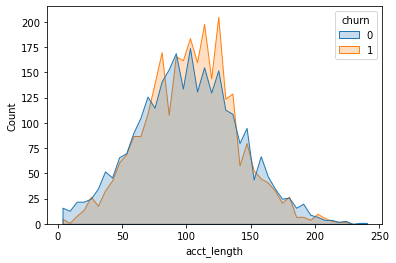

In [11]:
cont_features = [col for col in X.columns if X[col].dtype in [np.int64, np.float64]]
X_cont = X.loc[:, cont_features]
sm = SMOTE(random_state = random_state)
X_resampled, y_resampled = sm.fit_resample(X_cont, y) 
df_resampled = pd.concat([X_resampled, pd.DataFrame(y_resampled, columns = ['churn'])], axis=1)
sns.histplot(data=df_resampled, x = 'acct_length', hue = 'churn', element = 'poly');

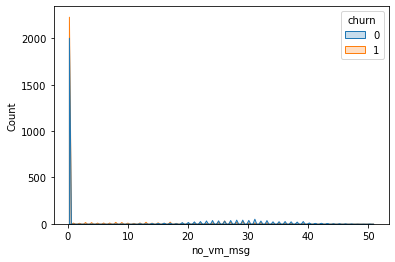

In [12]:
sns.histplot(data=df_resampled, x = 'no_vm_msg', hue = 'churn', element = 'poly');

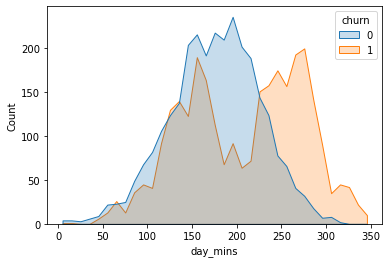

In [13]:
sns.histplot(data=df_resampled, x = 'day_mins', hue = 'churn', element = 'poly');

***day_mins***
- There appears to be a distinction between targets at day_mins = ~150 and day_mins = ~225
- I will try binning day_mins <= 225, and 150 < day_mins <= 225

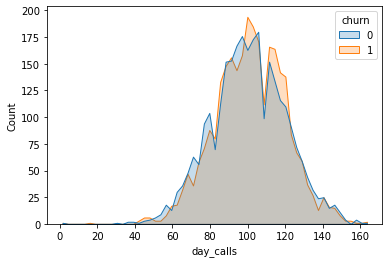

In [14]:
sns.histplot(data=df_resampled, x = 'day_calls', hue = 'churn', element = 'poly');

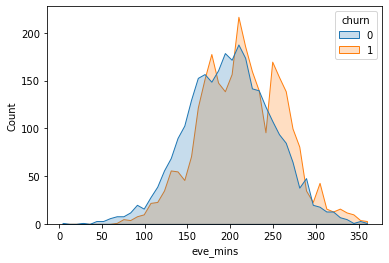

In [15]:
sns.histplot(data=df_resampled, x = 'eve_mins', hue = 'churn', element = 'poly');

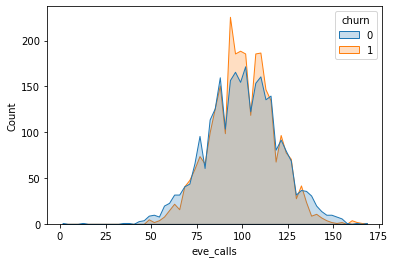

In [16]:
sns.histplot(data=df_resampled, x = 'eve_calls', hue = 'churn', element = 'poly');

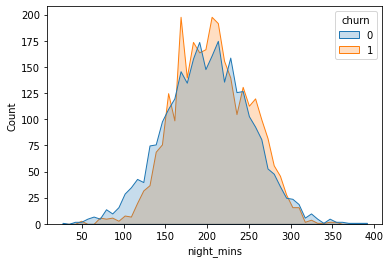

In [17]:
sns.histplot(data=df_resampled, x = 'night_mins', hue = 'churn', element = 'poly');

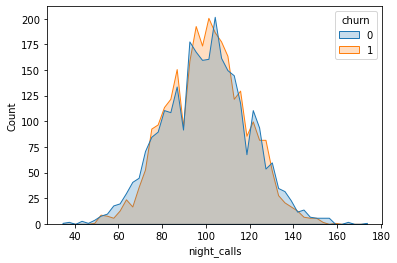

In [18]:
sns.histplot(data=df_resampled, x = 'night_calls', hue = 'churn', element = 'poly');

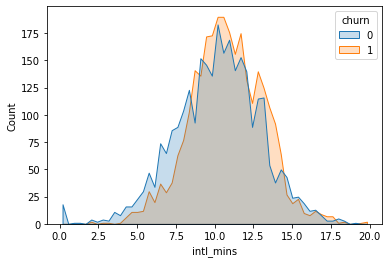

In [19]:
sns.histplot(data=df_resampled, x = 'intl_mins', hue = 'churn', element = 'poly');

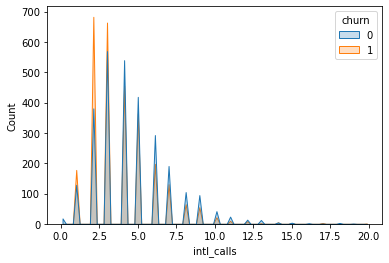

In [20]:
sns.histplot(data=df_resampled, x = 'intl_calls', hue = 'churn', element = 'poly');

***intl_calls***
- There appears to be a distinction between targets at intl_calls <= 3

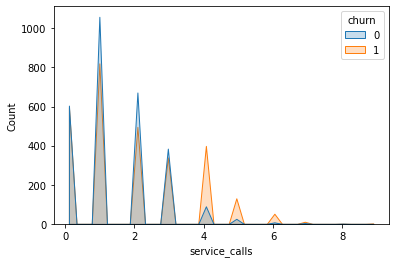

In [21]:
sns.histplot(data=df_resampled, x = 'service_calls', hue = 'churn', element = 'poly');

***service_calls***
- There appears to be a distinction between targets at service_calls <= 3

### Run Experiments

In [22]:
history = cl.ModelHistory('f1')
X = df.drop(columns = 'churn')
y = df.churn
X_train_all, X_hold_out, y_train_all, y_hold_out = train_test_split(X, y, random_state = random_state)
number_selector = make_column_selector(dtype_include='number')
string_selector = make_column_selector(dtype_include='object')
preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                        remainder='passthrough')
pipeline = make_pipeline(preprocessing,
                         SMOTE(random_state = random_state),
                         LogisticRegression(random_state = random_state, max_iter = 1000))
history.report(pipeline, X_train_all, y_train_all, 'Logistic Regression - Defaults')

Average Score: 0.4694795540498949


array([0.4729064 , 0.45045045, 0.44541485, 0.48305085, 0.49557522])

***Bin day_mins > 225***

In [23]:
feature_change = X_train_all.copy()
def day_mins_over_225(x):
    if x > 225:
        return 1
    else:
        return 0
    
feature_change['day_mins_over_225'] = feature_change.day_mins.apply(day_mins_over_225)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin day_mins 225; kept day_mins')

Average Score: 0.48668705020106884


array([0.50505051, 0.47111111, 0.43243243, 0.51082251, 0.51401869])

In [24]:
feature_change.drop(columns = 'day_mins', inplace = True)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin day_min 225; removed day_mins')

Average Score: 0.4770065283422301


array([0.50251256, 0.4628821 , 0.42477876, 0.50862069, 0.48623853])

***Bin 150 < day_mins <= 225***

In [25]:
feature_change = X_train_all.copy()
def day_mins_150_225(x):
    if x > 225:
        return 2
    elif x > 150:
        return 1
    else:
        return 0
    
feature_change['day_mins_150-225'] = feature_change.day_mins.apply(day_mins_150_225)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin day_mins 150&225; kept day_mins')

Average Score: 0.4745898493120471


array([0.46534653, 0.45333333, 0.46696035, 0.48510638, 0.50220264])

In [26]:
feature_change.drop(columns = 'day_mins', inplace = True)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin day_mins 150&225; removed day_mins')

Average Score: 0.4503980825851036


array([0.44660194, 0.42424242, 0.43290043, 0.48333333, 0.46491228])

***Bin intl_calls > 3***

In [27]:
def calls_over_3(x):
    if x > 3:
        return 1
    else:
        return 0
feature_change = X_train_all.copy()
feature_change['intl_calls_over_3'] = feature_change.intl_calls.apply(calls_over_3)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin intl_calls; kept intl_calls')

Average Score: 0.46454042162024906


array([0.45853659, 0.45021645, 0.4375    , 0.47863248, 0.49781659])

In [28]:
feature_change.drop(columns = 'intl_calls', inplace = True)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin intl_calls; removed intl_calls')

Average Score: 0.4672251396382673


array([0.45098039, 0.44933921, 0.45045045, 0.48535565, 0.5       ])

***Bin service_calls > 3***

In [29]:
feature_change = X_train_all.copy()
feature_change['service_calls_over_3'] = feature_change.service_calls.apply(calls_over_3)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin service_calls; kept service_calls')

Average Score: 0.563429597523543


array([0.53763441, 0.57      , 0.57276995, 0.5437788 , 0.59296482])

In [30]:
feature_change.drop(columns = 'service_calls', inplace = True)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin service_calls; removed service_calls')

Average Score: 0.5559776620748317


array([0.52688172, 0.56852792, 0.56338028, 0.5437788 , 0.57731959])

In [31]:
history.history

Name  Accuracy  \
0             Logistic Regression  0.563430   
8             Logistic Regression  0.555978   
1             Logistic Regression  0.486687   
2             Logistic Regression  0.477007   
3             Logistic Regression  0.474590   
4  Logistic Regression - Defaults  0.469480   
5             Logistic Regression  0.467225   
6             Logistic Regression  0.464540   
7             Logistic Regression  0.450398   

                                      Notes  
0     bin service_calls; kept service_calls  
8  bin service_calls; removed service_calls  
1           bin day_mins 225; kept day_mins  
2         bin day_min 225; removed day_mins  
3       bin day_mins 150&225; kept day_mins  
4                                            
5        bin intl_calls; removed intl_calls  
6           bin intl_calls; kept intl_calls  
7    bin day_mins 150&225; removed day_mins

***Binning service_calls > 3 and day_mins > 225 both improved F1 scores.  Will try applying both.***

In [32]:
feature_change = X_train_all.copy()
feature_change['service_calls_over_3'] = feature_change.service_calls.apply(calls_over_3)
feature_change['day_mins_over_225'] = feature_change.day_mins.apply(day_mins_over_225)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin service_calls & day_mins; kept both')

Average Score: 0.5675996810457478


array([0.5698324 , 0.56281407, 0.57142857, 0.55660377, 0.57731959])

In [33]:
feature_change.drop(columns = 'service_calls', inplace = True)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin service_calls & day_mins; drop service_calls')

Average Score: 0.5604565816900153


array([0.54748603, 0.57560976, 0.5645933 , 0.56074766, 0.55384615])

In [34]:
feature_change.drop(columns = 'day_mins', inplace = True)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin service_calls & day_mins; drop both')

Average Score: 0.5562779255128053


array([0.55865922, 0.55072464, 0.55454545, 0.56190476, 0.55555556])

In [35]:
feature_change = X_train_all.copy()
feature_change['service_calls_over_3'] = feature_change.service_calls.apply(calls_over_3)
feature_change['day_mins_over_225'] = feature_change.day_mins.apply(day_mins_over_225)
feature_change.drop(columns = 'day_mins', inplace = True)
history.report(pipeline, feature_change, y_train_all, 'Logistic Regression',
               'bin service_calls & day_mins; drop day_mins')

Average Score: 0.5547848168093197


array([0.55555556, 0.52427184, 0.5520362 , 0.56338028, 0.5786802 ])

In [36]:
history.history

Name  Accuracy  \
0              Logistic Regression  0.567600   
1              Logistic Regression  0.563430   
2              Logistic Regression  0.560457   
3              Logistic Regression  0.556278   
4              Logistic Regression  0.555978   
12             Logistic Regression  0.554785   
5              Logistic Regression  0.486687   
6              Logistic Regression  0.477007   
7              Logistic Regression  0.474590   
8   Logistic Regression - Defaults  0.469480   
9              Logistic Regression  0.467225   
10             Logistic Regression  0.464540   
11             Logistic Regression  0.450398   

                                               Notes  
0            bin service_calls & day_mins; kept both  
1              bin service_calls; kept service_calls  
2   bin service_calls & day_mins; drop service_calls  
3            bin service_calls & day_mins; drop both  
4           bin service_calls; removed service_calls  
12       bin service_calls & day_mins; drop day_mins  
5                    bin day_mins 225; kept day_mins  
6                  bin day_min 225; removed day_mins  
7                bin day_mins 150&225; kept day_mins  
8                                                     
9                 bin intl_calls; removed intl_calls  
10                   bin intl_calls; kept intl_calls  
11            bin day_mins 150&225; removed day_mins

***Best model binned service_calls > 3 and day_mins > 225***
- Will create model and determine baseline F1-score

In [37]:
X_train_final = X_train_all.copy()
X_hold_out_final = X_hold_out.copy()
X_train_final['service_calls_over_3'] = X_train_final.service_calls.apply(calls_over_3)
X_hold_out_final['service_calls_over_3'] = X_hold_out_final.service_calls.apply(calls_over_3)
X_train_final['day_mins_over_225'] = X_train_final.day_mins.apply(day_mins_over_225)
X_hold_out_final['day_mins_over_225'] = X_hold_out_final.day_mins.apply(day_mins_over_225)
pipeline = make_pipeline(preprocessing,
                         SMOTE(random_state = random_state),
                         LogisticRegression(random_state = random_state, max_iter = 1000))
pipeline.fit(X_train_final, y_train_all)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8eaf03ee0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8e132abe0>)])),
                ('smote', SMOTE(random_state=45)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=45))])

In [38]:
train_preds = pipeline.predict(X_train_final)
hold_out_preds = pipeline.predict(X_hold_out_final)

train_f1 = f1_score(y_train_all, train_preds)
test_f1 = f1_score(y_hold_out, hold_out_preds)
print('Training F1-Score: {:.2f}'.format(train_f1))
print('Testing F1-Score: {:.2f}'.format(test_f1))

Training F1-Score: 0.61
Testing F1-Score: 0.57


In [39]:
df.head()

state  acct_length intl_plan vm_plan  no_vm_msg  day_mins  day_calls  \
0    KS          128        no     yes         25     265.1        110   
1    OH          107        no     yes         26     161.6        123   
2    NJ          137        no      no          0     243.4        114   
3    OH           84       yes      no          0     299.4         71   
4    OK           75       yes      no          0     166.7        113   

   eve_mins  eve_calls  night_mins  night_calls  intl_mins  intl_calls  \
0     197.4         99       244.7           91       10.0           3   
1     195.5        103       254.4          103       13.7           3   
2     121.2        110       162.6          104       12.2           5   
3      61.9         88       196.9           89        6.6           7   
4     148.3        122       186.9          121       10.1           3   

   service_calls  churn           city  
0              1      0  San_Francisco  
1              1      0  San_Francisco  
2              0      0  San_Francisco  
3              2      0       San_Jose  
4              3      0  San_Francisco

In [40]:
# Save processed data
df['service_calls_over_3'] = df.service_calls.apply(calls_over_3)
df['day_mins_over_225'] = df.day_mins.apply(day_mins_over_225)
df.to_csv('../../data/processed/churn_dataset.csv')